# RFA-based NN growth experiment (WIP)
# TODO

In [1]:
import ipycanvas

training_canvas, ranks_canvas, input_domain_canvas = ipycanvas.Canvas(), ipycanvas.Canvas(), ipycanvas.Canvas()

training_canvas.width = training_canvas.height = 1000
ranks_canvas.width = 1200
ranks_canvas.height = 600
input_domain_canvas.width = input_domain_canvas.height = 600
training_canvas.font = ranks_canvas.font = input_domain_canvas.font = "30px arial"

args = ('Results will appear as processed', training_canvas.width / 4, training_canvas.height / 3)
training_canvas.fill_text(*args); ranks_canvas.fill_text(*args); input_domain_canvas.fill_text(*args)

In [2]:
training_canvas

Canvas(height=1000, width=1000)

In [3]:
ranks_canvas

Canvas(height=600, width=1200)

In [4]:
input_domain_canvas

Canvas(height=600, width=600)

In [5]:
from experiment import execute_experiment
from plots import plot_effective_rank_and_detected_noise_on_canvas, plot_samples_and_model_activation_on_canvas

experiment_results = execute_experiment(
    seed=12345,
    noise_rate=0.,
    within_cluster_variance=1. / 50.,
    input_dimension=300,
    sample_size=5000,
    batch_size=5000,
    epochs=1000,
    learning_rate=0.05,
    hidden_units=8,
    initialization_variance=1 / (32. * 500.),
    runs_per_model=1,
    clusters_per_class=2,
    convergence_epsilon=0.1,
    save_models_path='./models/',
    save_experiments_path='./experiments/',
    saving_epochs_interval=1,
    plot_results_on_canvas=training_canvas,
    callbacks=[
        plot_effective_rank_and_detected_noise_on_canvas(ranks_canvas), 
        plot_samples_and_model_activation_on_canvas(input_domain_canvas)
    ]
)

In [6]:
import numpy, torch

from experiment import TwoLayerNeuralNet
from settings.noisy_xor import get_dataloader
from utils.optimization import Accuracy, initialize

initialize(experiment_results['seed'])

data, rotation_matrix = get_dataloader(**experiment_results)
_, (inputs, labels) = next(enumerate(data))

model = TwoLayerNeuralNet.load('./models/', {**experiment_results, 'run': 0})
predictions = model(torch.concatenate([inputs, labels], dim=1))
print(f'Accuracy: {Accuracy(predictions, labels)}')

loss = torch.nn.BCEWithLogitsLoss(reduction='none')(predictions, labels)

Accuracy: 0.9968000054359436


In [7]:
input_dimension = experiment_results['input_dimension']
clusters_centers = [[1., 0.], [0., 1.], [-1., 0.], [0., -1.]]

extended_clusters_centers = numpy.concatenate([
    numpy.array(clusters_centers), 
    numpy.repeat(numpy.repeat(0., input_dimension - 2)[numpy.newaxis, :], len(clusters_centers), axis=0)
], axis=1)

extended_clusters_centers = torch.tensor(numpy.matmul(extended_clusters_centers, rotation_matrix), dtype=torch.float)

inputs_cluster = inputs.mm(extended_clusters_centers.t()).argmin(dim=1)
data = torch.concatenate([model.activations.norm(dim=1).unsqueeze(1), loss], dim=1)

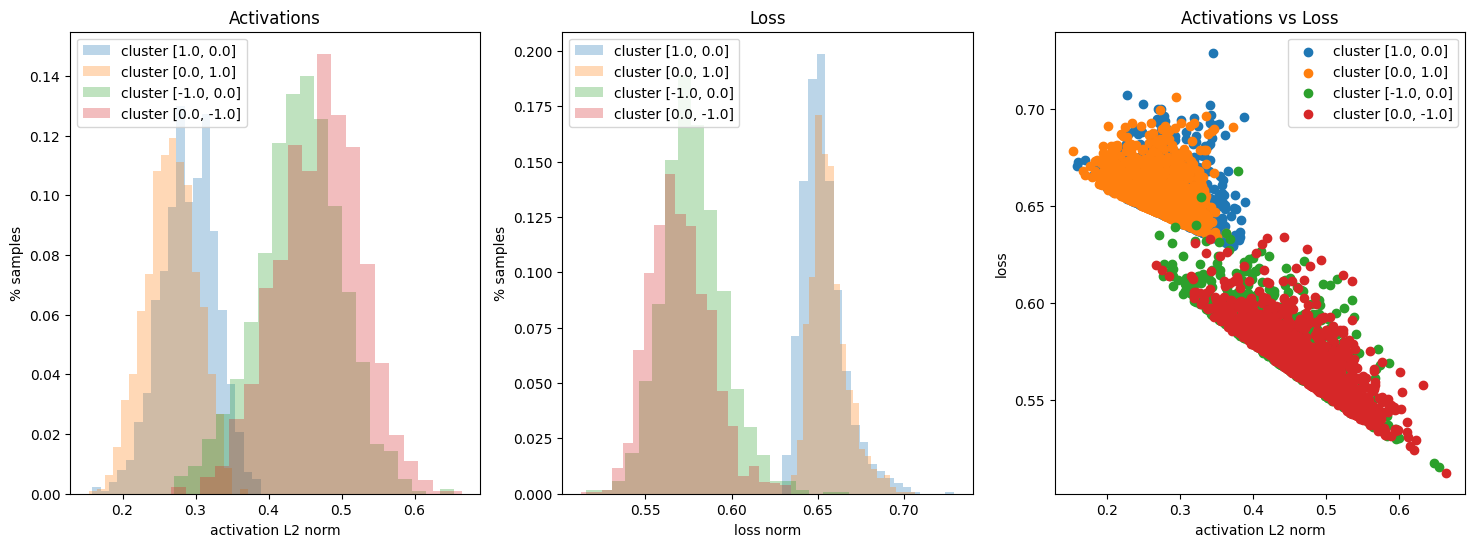

In [8]:
import matplotlib.pyplot

histogram_resolution = 20

def histogram_bars(histogram_frequencies, histogram_bins):
    histogram_bins = histogram_bins.detach().cpu().numpy()[:-1]
    histogram_bins_pace = histogram_bins[1] - histogram_bins[0]
    histogram_bins += histogram_bins_pace / 2.
    histogram_frequencies = histogram_frequencies.detach().cpu().numpy()
    return histogram_bins, histogram_frequencies / histogram_frequencies.sum(), histogram_bins_pace

fig, (activations_ax, loss_ax, scatter_ax) = matplotlib.pyplot.subplots(1, 3, figsize=(18, 6))

activations_ax.set_title('Activations')
activations_ax.set_xlabel('activation L2 norm')
activations_ax.set_ylabel('% samples')

loss_ax.set_title('Loss')
loss_ax.set_xlabel('loss norm')
loss_ax.set_ylabel('% samples')

scatter_ax.set_title('Activations vs Loss')
scatter_ax.set_xlabel('activation L2 norm')
scatter_ax.set_ylabel('loss')

for cluster_index, cluster in zip(inputs_cluster.unique().tolist(), [[1., 0.], [0., 1.], [-1., 0.], [0., -1.]]):
    activations_ax.bar(*histogram_bars(*torch.histogram(data[inputs_cluster==cluster_index][:, 0], histogram_resolution)), label=f'cluster {cluster}', alpha=0.3)
    loss_ax.bar(*histogram_bars(*torch.histogram(data[inputs_cluster==cluster_index][:, 1], histogram_resolution)), label=f'cluster {cluster}', alpha=0.3)
    scatter_ax.scatter(data[inputs_cluster==cluster_index][:, 0].detach().numpy(), data[inputs_cluster==cluster_index][:, 1].detach().numpy(), label=f'cluster {cluster}')

for ax in (activations_ax, loss_ax, scatter_ax): ax.legend()

fig